Make sure that the tail part of the forward model applied to the (mock) observations is perfectly consistent with what happens within the main CosmoGrid forward model (both for fiducial and grid cosmologies)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import files, redshift, clustering, lensing, maps, observation

# select version

In [3]:
# # with high pass filter
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v11/extended.yaml"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v9/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/extended/tfrecords/fiducial/validation/DESy3_fiducial_dmb_0000.tfrecord"

# # # no smoothing
# # conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v9/linear_bias_no_smoothing.yaml"
# # tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v9/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

In [4]:
# with high pass filter
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v11/power_law.yaml"
# tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v9/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"
tfr_pattern = "/pscratch/sd/a/athomsen/v11desy3/v11/power_law/tfrecords/fiducial/DESy3_fiducial_dmb_0000.tfrecord"

In [5]:
conf = files.load_config(conf)

metacal_bins = conf["survey"]["metacal"]["z_bins"]
maglim_bins = conf["survey"]["maglim"]["z_bins"]
n_z = len(metacal_bins) + len(maglim_bins)

# pixels
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)
data_vec_len = len(data_vec_pix)

# gnomview
x_deg = 10
y_deg = x_deg

x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# for the rotated DES footprint
rot = (90, -30, 0)

24-10-25 00:50:02     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


# from .tfrecord

In [6]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    apply_m_bias=False,
    shape_noise_scale=0.0,
    poisson_noise_scale=0.0,
)

24-10-25 00:50:03 base_pipelin WAR   The noise scaling is only implemented for the maps, not the power spectra 
24-10-25 00:50:03     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-25 00:50:03     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


In [7]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=None,
    is_eval=True,
)

for dv, _, index in fidu_dset.take(1):
    i_example = index[0].numpy()
    i_noise = index[1].numpy()

    print(f"i_example = {i_example}, i_noise = {i_noise}")

print(dv.shape)

24-10-25 00:50:06 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-10-25 00:50:06 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-10-25 00:50:06 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-10-25 00:50:06 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-10-25 00:50:06 fiducial_pip INF   Interleaving with n_readers = 1 
24-10-25 00:50:08 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-10-25 00:50:09 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warnin

# from .h5

In [8]:
wl_gamma_map, gc_count_map = observation.forward_model_cosmogrid(
    "/global/cfs/cdirs/des/cosmogrid/v11desy3/CosmoGrid/v11desy3/fiducial/cosmo_fiducial/perm_0000",    
    conf=conf,
    with_lensing=True,
    with_clustering=True,
    noisy=False,
)

24-10-25 00:50:13     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-25 00:50:14     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-25 00:51:01 observation. INF   Using tomo_Aia=[0.38089597 0.46084908 0.5600504  0.65948504] from the config 
24-10-25 00:51:01 observation. INF   Using bta=None from the function call 
24-10-25 00:51:01 observation. INF   Using standard NLA 
24-10-25 00:51:07     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-25 00:51:31 observation. INF   Using tomo_bg=[1.3433586 1.4218498 1.4996815 1.5668583] from the config 
24-10-25 00:51:31 observation. INF   No quadratic biasing 


In [9]:
h5_obs, _, _ = observation.forward_model_observation_map(
    conf=conf,
    wl_gamma_map=wl_gamma_map,
    gc_count_map=gc_count_map,
    apply_norm=False,
    with_padding=True,
    nest=False,
)

24-10-25 00:51:32     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 
24-10-25 00:51:32     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_fiducial_512.h5 


# comparison

In [10]:
# .tfrecord
tf_map = np.zeros((n_pix, n_z))
tf_map[data_vec_pix] = dv[0]

# # original .h5
# h5_original_map = maps.tomographic_reorder(h5_original.copy(), r2n=True)

# forward modeled .h5
h5_obs_map = np.zeros((n_pix, n_z))
h5_obs_map[data_vec_pix] = h5_obs

# differences
# without_obs_fm = tf_map - h5_original_map
with_obs_fm = tf_map - h5_obs_map

print(np.mean(tf_map, axis=0) / np.mean(h5_obs_map, axis=0))

[1.0000182  1.00001892 0.99998861 1.00001081 1.         1.00000005
 1.00000003 0.99999996]


### weak lensing

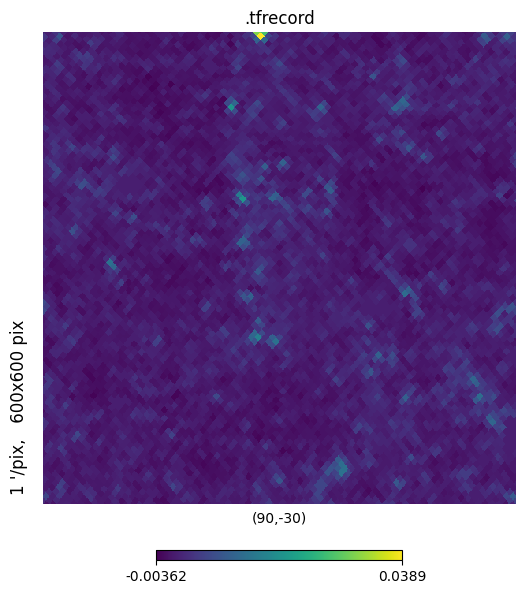

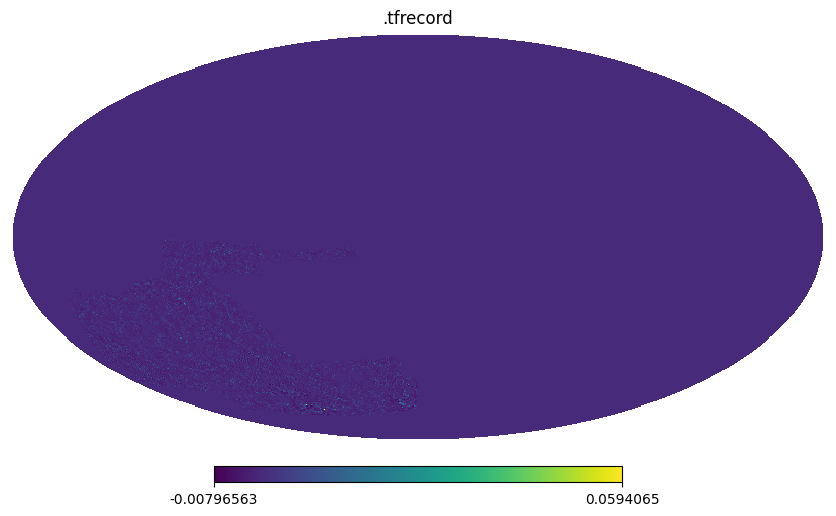

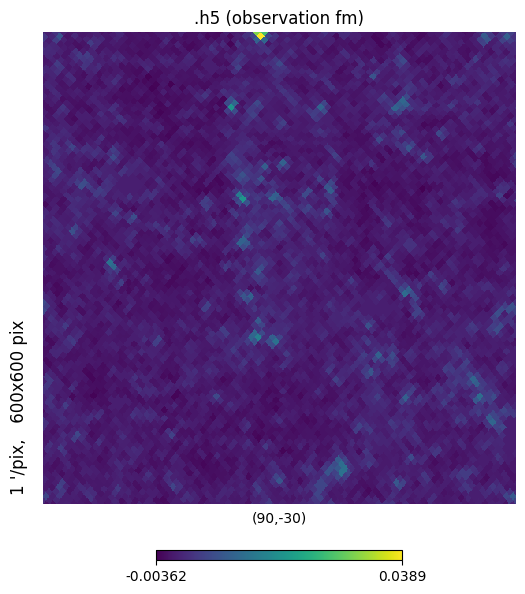

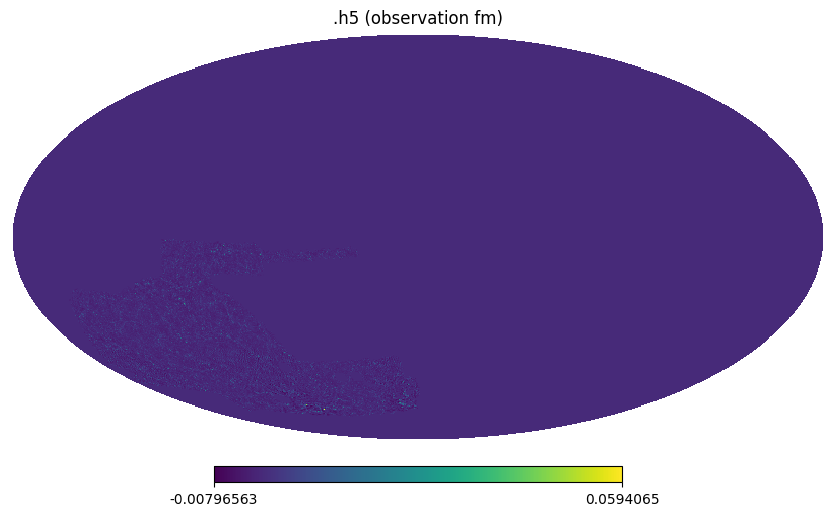

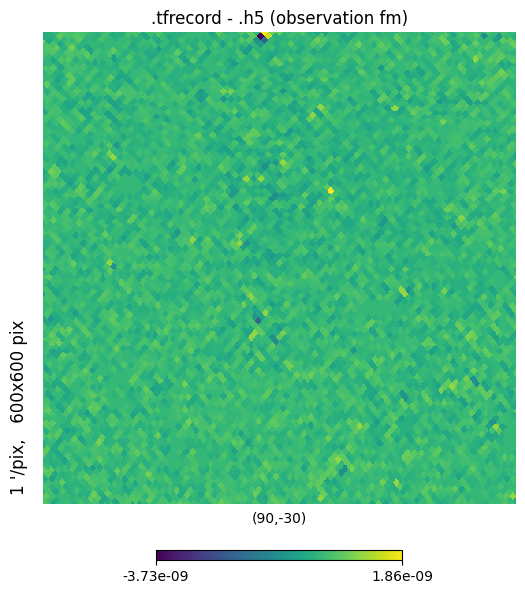

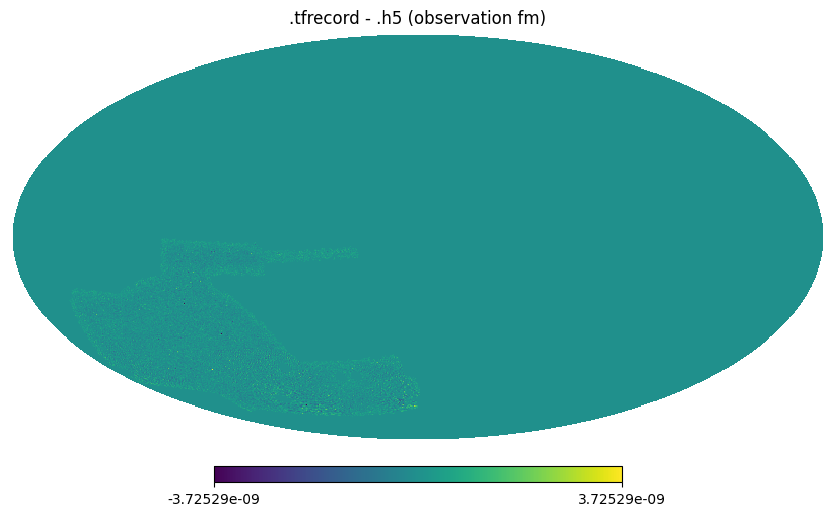

In [11]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 0

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")
hp.mollview(tf_map[:,i_z], nest=True, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")
hp.mollview(h5_obs_map[:,i_z], nest=True, title=".h5 (observation fm)")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")
hp.mollview(with_obs_fm[:,i_z], nest=True, title=".tfrecord - .h5 (observation fm)")

# original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")

### galaxy clustering

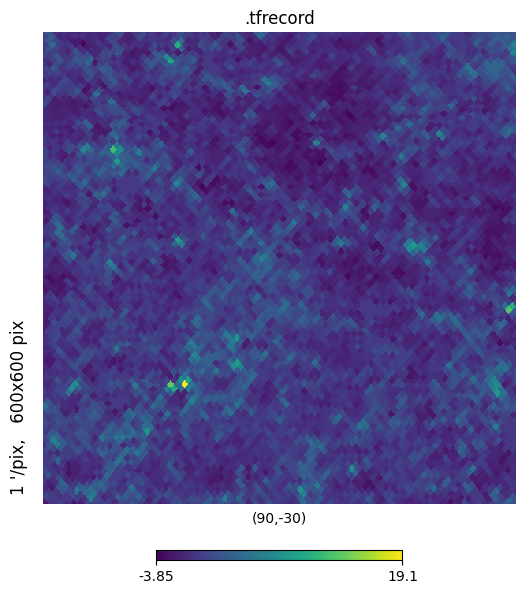

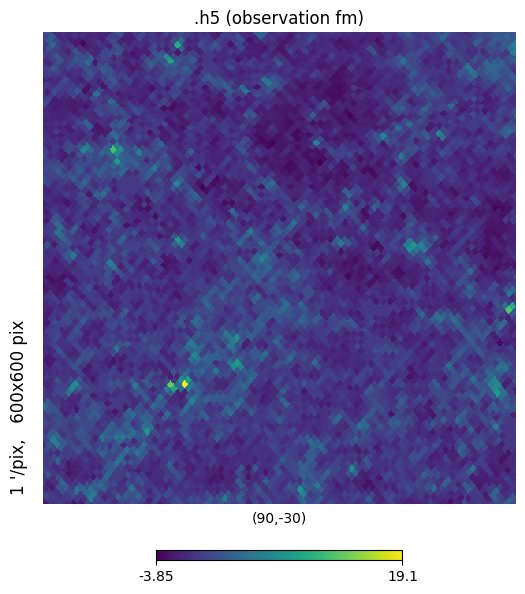

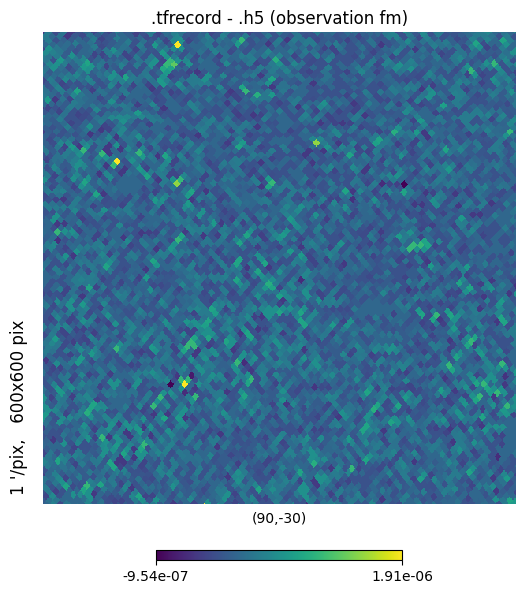

In [12]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 5

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")
# hp.mollview(tf_map[:,i_z], nest=True, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")
# hp.mollview(h5_obs_map[:,i_z], nest=True, title=".tfrecord")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")
# hp.mollview(with_obs_fm[:,i_z], nest=True, title=".tfrecord")

# hp.gnomview((h5_obs_map[:,i_z] - np.mean(h5_obs_map[:,i_z]) - (tf_map[:,i_z] - np.mean(tf_map[:,i_z]))), nest=True, title=".tfrecord - .h5 (observation fm) and means")
# hp.gnomview(without_mean[:,i_z], nest=True, title=".tfrecord - .h5 (observation fm) without means")


# hp.gnomview(tf_map[:,i_z]-h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord / .h5 (observation fm)")
# hp.gnomview(tf_map[:,i_z]/h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord / .h5 (observation fm)")
# hp.gnomview(h5_obs_map[:,i_z]/tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm) / .tfrecord")

# # original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# # hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")

# old

# from .h5

In [13]:
# conf = files.load_config(conf)

# # pixels
# n_side = conf["analysis"]["n_side"]
# n_pix = conf["analysis"]["n_pix"]
# data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)
# data_vec_len = len(data_vec_pix)

# # fiducial values
# Aia = conf["analysis"]["fiducial"]["Aia"]
# n_Aia = conf["analysis"]["fiducial"]["n_Aia"]


# # redshift dependence
# z0 = conf["analysis"]["modelling"]["z0"]

# metacal_bins = conf["survey"]["metacal"]["z_bins"]
# tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
# tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

# maglim_bins = conf["survey"]["maglim"]["z_bins"]
# tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
# tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)

# bg = conf["analysis"]["fiducial"]["bg"]
# n_bg = conf["analysis"]["fiducial"]["n_bg"]
# tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)
# # tomo_bg = np.array([conf["analysis"]["fiducial"][bg] for bg in conf["analysis"]["params"]["bg"]["linear"]])

# n_z = len(metacal_bins) + len(maglim_bins)

# # gnomview
# x_deg = 10
# y_deg = x_deg

# x_pix = 600
# y_pix = x_pix

# # in arcminute / pixel
# reso = x_deg / x_pix * 60

# # for the rotated DES footprint
# rot = (90, -30, 0)

# hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

### load the full sky maps

In [14]:
# %time
# i_perm = 0

# fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/CosmoGrid/v11desy3/fiducial/cosmo_fiducial"
# # fidu_dir = "/pscratch/sd/a/athomsen/v11desy3/fiducial/cosmo_fiducial"

# with h5py.File(os.path.join(fidu_dir, f"perm_{i_perm:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
    
#     # print(f.keys())
#     # print(f["map"].keys())
    
#     kg = []
#     ia = []
#     for z_bin in metacal_bins:
#         kg.append(hp.ud_grade(f[f"map/kg/{z_bin}"], n_side))
#         ia.append(hp.ud_grade(f[f"map/ia/{z_bin}"], n_side))
#     kg = np.stack(kg, axis=-1)
#     ia = np.stack(ia, axis=-1)

#     # create the noiseless fiducial map
#     wl_h5 = kg + tomo_Aia * ia

#     dg = []
#     for z_bin in maglim_bins:
#         dg.append(hp.ud_grade(f[f"map/dg/{z_bin}"], n_side))
#     dg = np.stack(dg, axis=-1)

#     # create the noiseless fiducial map
#     gc_h5 = clustering.galaxy_density_to_count(tomo_n_gal_maglim, dg/np.mean(dg), tomo_bg, nest=False)

# print(wl_h5.shape)
# print(gc_h5.shape)

# h5_original = np.concatenate([wl_h5, gc_h5], axis=-1)

# forward model the .h5 as an observation

### weak lensing

In [15]:
# kappa2gamma_fac, gamma2kappa_fac, _ = lensing.get_kaiser_squires_factors(3*n_side-1)

# # wl_h5_obs = np.zeros((data_vec_len, 4))
# gamma1 = []
# gamma2 = []
# for i in range(4):
#     # kappa -> gamma (full sky)
#     kappa_alm = hp.map2alm(
#         wl_h5[:,i],
#         use_pixel_weights=True,
#         datapath=hp_datapath,
#     )

#     gamma_alm = kappa_alm * kappa2gamma_fac
#     _, gamma1_full, gamma2_full = hp.alm2map(
#         [np.zeros_like(gamma_alm), gamma_alm, np.zeros_like(gamma_alm)], nside=n_side
#     )
    
#     patch_pix = patches_pix_dict["metacal"][i][0]
#     gamma1_patch = np.zeros(n_pix, dtype=np.float32)
#     gamma1_patch[patch_pix] = gamma1_full[patch_pix]

#     gamma2_patch = np.zeros(n_pix, dtype=np.float32)
#     gamma2_patch[patch_pix] = gamma2_full[patch_pix]


#     gamma1.append(gamma1_patch)
#     gamma2.append(gamma2_patch)
    
# gamma1 = np.stack(gamma1, axis=-1)
# gamma2 = np.stack(gamma2, axis=-1)

# h5_wl_gamma_map = np.stack([gamma1, gamma2], axis=-1)

### galaxy clustering

In [16]:
# patch_pix = patches_pix_dict["maglim"][0]
# maglim_mask = files.get_tomo_dv_masks(conf)["maglim"]

# dg_patch = np.zeros_like(dg)

# # cut out the footprint
# dg_patch[patch_pix] = dg[patch_pix]

# # subtract and divide by mean (within the patch)
# dg_patch[patch_pix] = (dg_patch[patch_pix] - np.mean(dg_patch[patch_pix])) / np.mean(dg_patch[patch_pix])

# # density contrast to count
# h5_gc_count_map = clustering.galaxy_density_to_count(
#     tomo_n_gal_maglim, 
#     dg_patch, 
#     tomo_bg, 
#     conf=conf, 
#     nest=False,
# )

In [17]:
# patch_pix = patches_pix_dict["maglim"][0]
# maglim_mask = files.get_tomo_dv_masks(conf)["maglim"]

# dg_patch = np.zeros_like(dg)

# # cut out the footprint
# dg_patch[patch_pix] = dg[patch_pix]

# # subtract and divide by mean (within the patch)
# dg_patch[patch_pix] = (dg_patch[patch_pix] - np.mean(dg_patch[patch_pix])) / np.mean(dg_patch[patch_pix])

# dg_patch = maps.tomographic_reorder(dg_patch, r2n=True)
# dg_dv = dg_patch[data_vec_pix]

# # density contrast to count
# h5_gc_count_dv = clustering.galaxy_density_to_count(
#     tomo_n_gal_maglim, 
#     dg_dv, 
#     tomo_bg, 
#     mask=maglim_mask,
#     nest=True,
# )

# h5_gc_count_map = np.zeros((n_pix,4))
# h5_gc_count_map[data_vec_pix] = h5_gc_count_dv
# h5_gc_count_map = maps.tomographic_reorder(h5_gc_count_map, n2r=True)

In [18]:
# h5_obs, _= observation.forward_model_observation_map(
#     wl_gamma_map=h5_wl_gamma_map,
#     gc_count_map=h5_gc_count_map,
#     conf=conf,
#     apply_norm=False,
#     with_padding=True,
#     nest=False,
# )

In [19]:
# # gnomview
# x_deg = 10
# y_deg = x_deg

# x_pix = 600
# y_pix = x_pix

# # in arcminute / pixel
# reso = x_deg / x_pix * 60

# # for the rotated DES footprint
# rot = (90, -20, 0)

# # weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
# i_z = 6

# tf_map_masked = tf_map.copy()
# tf_map_masked[tf_map==0] = hp.UNSEEN

# h5_obs_map_masked = h5_obs_map.copy()
# h5_obs_map_masked[h5_obs_map==0] = hp.UNSEEN

# tf_mask = tf_map==0
# with_obs_fm_masked = with_obs_fm.copy()
# with_obs_fm_masked[tf_mask] = hp.UNSEEN

# # .tfrecord
# hp.gnomview(tf_map_masked[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")

# # forward modeled .h5
# hp.gnomview(h5_obs_map_masked[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")

# # differences
# hp.gnomview(with_obs_fm_masked[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")